In [159]:
import importlib
import pandas as pd
import analysis_functions as af
import analysis_functions_behv as af_b
import preprocess_behav2p as preprocess
importlib.reload(af_b)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from scipy import stats
from scipy.io import loadmat
from scipy.ndimage import uniform_filter1d
import os
import pickle
from matplotlib.animation import FuncAnimation
from scipy.ndimage import gaussian_filter1d
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon
import pandas as pd
import openpyxl

In [2]:
# Load the ctl data
desktop_path = os.path.expanduser(r"C:\Users\HAOXUAN YIN\Desktop\behv data\v1ctldata_full.pkl")
with open(desktop_path, 'rb') as f:
    data_ctl_full = pickle.load(f)

desktop_path = os.path.expanduser(r"C:\Users\HAOXUAN YIN\Desktop\behv data\v1_ctldata.pkl")
with open(desktop_path, 'rb') as f:
    data_ctl = pickle.load(f)

time_ctl = loadmat(r"C:\Users\HAOXUAN YIN\Desktop\behv data\time_ctldata.mat")
time_full_ctl = loadmat(r"C:\Users\HAOXUAN YIN\Desktop\behv data\time_ctldata_full.mat")
for ani in data_ctl:
    data_ctl[ani]['time'] = np.squeeze(time_ctl['time'][0][ani])
for ani in data_ctl_full:
    data_ctl_full[ani]['time'] = np.squeeze(time_full_ctl['t'][0][ani])

reward_trigger_ctl = loadmat(r"C:\Users\HAOXUAN YIN\Desktop\behv data\rewardtrigger_ctl.mat")
for ani in data_ctl_full:
    del data_ctl_full[ani]['reward_indices']
    data_ctl_full[ani]['reward_indices'] = np.squeeze(reward_trigger_ctl['rewardtrigger_ctl'][0][ani])

reward_trigger_ctl_ds = loadmat(r"C:\Users\HAOXUAN YIN\Desktop\behv data\downsampled_rewardtrigger_ctl.mat")
for ani in data_ctl:
    del data_ctl[ani]['reward_indices']
    data_ctl[ani]['reward_indices'] = np.squeeze(reward_trigger_ctl_ds['downsampled_rewardtrigger_ctl'][0][ani])

# Load the tst data 
desktop_path = os.path.expanduser(r"C:\Users\HAOXUAN YIN\Desktop\behv data\v1tstdata_full.pkl")
with open(desktop_path, 'rb') as f:
    data_tst_full = pickle.load(f)
    data_tst_full.pop(13)
    
desktop_path = os.path.expanduser(r"C:\Users\HAOXUAN YIN\Desktop\behv data\v1_tstdata.pkl")
with open(desktop_path, 'rb') as f:
    data_tst = pickle.load(f)
    data_tst.pop(13) # no speed and lick data in this animal

time_tst = loadmat(r"C:\Users\HAOXUAN YIN\Desktop\behv data\time_tstdata.mat")
time_full_tst = loadmat(r"C:\Users\HAOXUAN YIN\Desktop\behv data\time_tstdata_full.mat")
for ani in data_tst:
    data_tst[ani]['time'] = np.squeeze(time_tst['time'][0][ani])
for ani in data_tst_full:
    data_tst_full[ani]['time'] = np.squeeze(time_full_tst['time'][0][ani])

reward_trigger_tst = loadmat(r"C:\Users\HAOXUAN YIN\Desktop\behv data\rewardtrigger_tst.mat")
for ani in data_tst_full:
    del data_tst_full[ani]['reward_indices']
    data_tst_full[ani]['reward_indices'] = np.squeeze(reward_trigger_tst['rewardtrigger_tst'][0][ani])

reward_trigger_tst_ds = loadmat(r"C:\Users\HAOXUAN YIN\Desktop\behv data\downsampled_rewardtrigger_tst.mat")
for ani in data_tst:
    del data_tst[ani]['reward_indices']
    data_tst[ani]['reward_indices'] = np.squeeze(reward_trigger_tst_ds['downsampled_rewardtrigger_tst'][0][ani])

-------------------------

In [ ]:
# Lick Detection

animal 0 97 licks in trial 100 to 105
animal 1 57 licks in trial 100 to 105
animal 2 95 licks in trial 100 to 105
animal 3 64 licks in trial 100 to 105
animal 4 127 licks in trial 100 to 105
animal 5 142 licks in trial 100 to 105
animal 6 154 licks in trial 100 to 105
animal 7 40 licks in trial 100 to 105
animal 8 98 licks in trial 100 to 105
animal 9 104 licks in trial 100 to 105
animal 10 84 licks in trial 100 to 105
animal 11 152 licks in trial 100 to 105
animal 12 71 licks in trial 100 to 105
animal 13 93 licks in trial 100 to 105


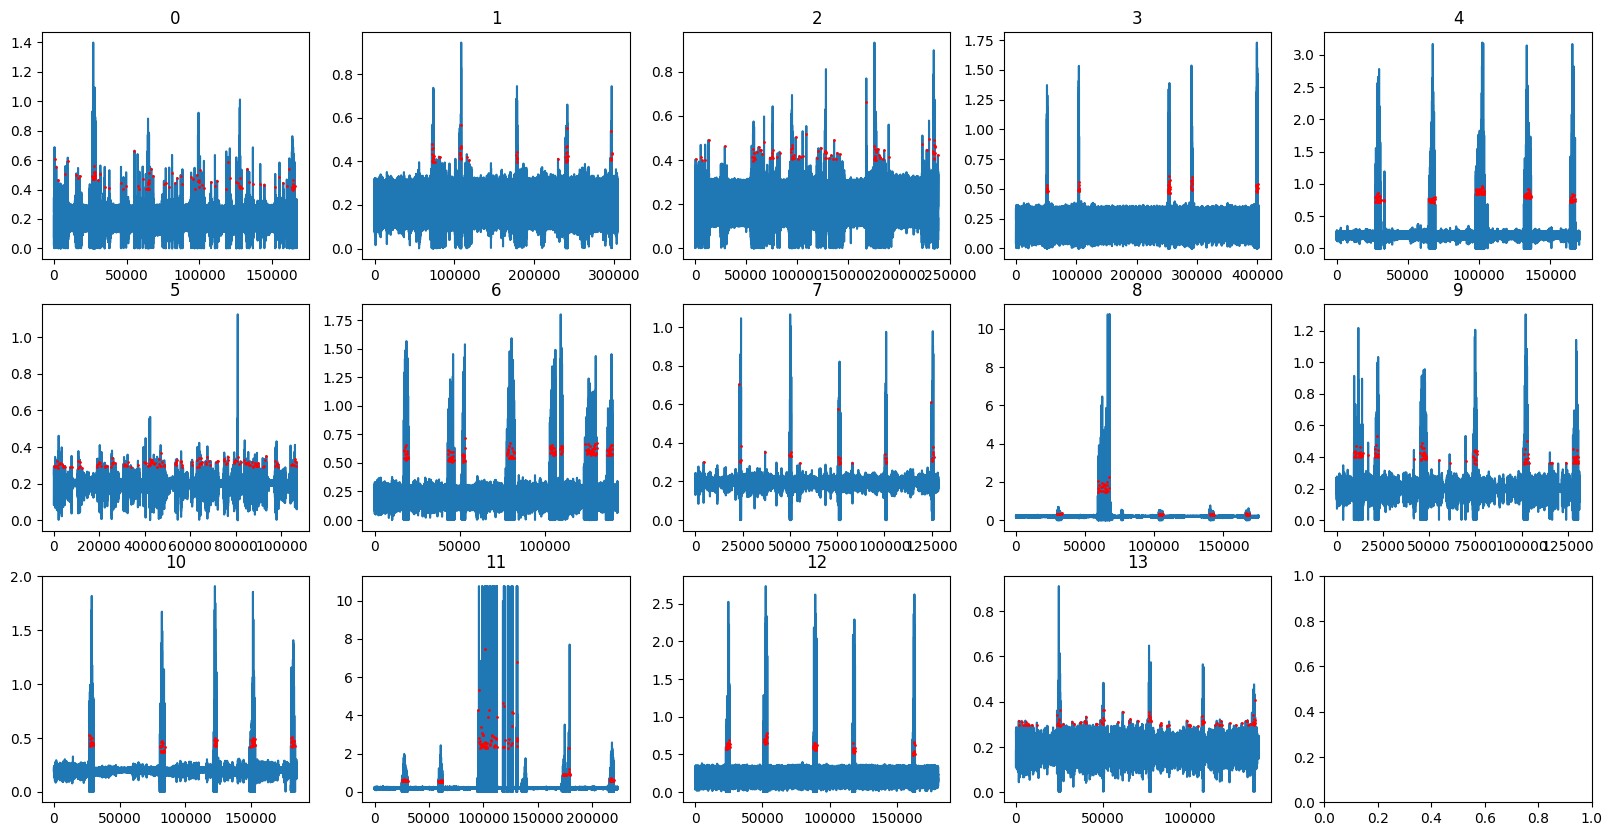

In [109]:
# find lick indices in nondownsampled data and get lick_onsets/lick_records/lick_rate in downsampled data--- ctl

lick_onsets_ctl = {}

max_valid = 5
min_interval = 129   # refractory period in samples (ms)   the maximum ILI of C57 mice is around 129ms (see https://pmc.ncbi.nlm.nih.gov/articles/PMC3219432/)

for ani in data_ctl_full:
    lick_onsets_ctl[ani] = []
    lick_signal = np.clip(data_ctl_full[ani]['lick'], a_min=None, a_max=max_valid)
    # lick_signal = gaussian_filter1d(lick_signal_raw, sigma=0.1)  # no smoothing

    trial_start_indices = data_ctl_full[ani]['trial_start_indices']

    # iterate over all trials
    for tri in range(len(trial_start_indices) - 1):
        start = trial_start_indices[tri]
        end = trial_start_indices[tri + 1]
        segment = lick_signal[start:end]
        
        # compute per-trial threshold
        threshold = np.median(segment) + 3 * np.std(segment)

        # find threshold crossings
        above = segment > threshold
        crossings = np.where((~above[:-1]) & (above[1:]))[0] + 1 

        # convert local indices to absolute indices
        if len(crossings) > 0:
            # enforce refractory period (in absolute frame)
            abs_cross = start + crossings
            if len(abs_cross) > 0:
                filtered = [abs_cross[0]]
                for idx in abs_cross[1:]:
                    if idx - filtered[-1] >= min_interval:
                        filtered.append(idx)
                lick_onsets_ctl[ani].extend(filtered)    #  get the lick_onsets in full data


# convert to numpy arrays and visualise 
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()

for ani in lick_onsets_ctl:
    lick_onsets_ctl[ani] = np.array(lick_onsets_ctl[ani])

    trial_start_indices = data_ctl_full[ani]['trial_start_indices']
    start_trial = 100
    end_trial = 105
    start, end = trial_start_indices[start_trial], trial_start_indices[end_trial]  # check lick onset between trial... and ...
    lick_signal = data_ctl_full[ani]['lick'] 
    axes[ani].plot(lick_signal[start:end])
    axes[ani].set_title(f'{ani}')
    # axes[ani].axhline(0.2,c='red')

    onsets_in_segment = lick_onsets_ctl[ani][(lick_onsets_ctl[ani] >= start) & (lick_onsets_ctl[ani] < end)]  # array of lick onsets in segment
    print('animal',ani, len(onsets_in_segment), 'licks in trial', start_trial, 'to', end_trial)
    rel_onsets = onsets_in_segment - start
    axes[ani].scatter(
        rel_onsets,
        lick_signal[onsets_in_segment],
        color='red', s=1, zorder=3
    )

# Calculate the Lick Rate in full data sampled at 1000Hz (not very helpful)
lick_rate_ctl = {}
window_ms = 200  # 1-second sliding window
sampling_rate = 1000  # Hz
for ani in data_ctl_full:
    # Make binary lick signal
    n_samples = len(data_ctl_full[ani]['time'])
    lick_signal = np.zeros(n_samples)
    lick_signal[lick_onsets_ctl[ani]] = 1
    # Sliding window average (licks per sample)
    rate_per_sample = uniform_filter1d(lick_signal, size=window_ms, mode='constant')
    # Convert to licks per second
    lick_rate_ctl[ani] = rate_per_sample * sampling_rate

# Find the lick indices in the downsampled data and get a new lick_onsets_ctl using the time variable
lick_onsets_ctl_ds = {}
for ani in data_ctl_full:
    times_full = data_ctl_full[ani]['time']
    times_ds = data_ctl[ani]['time']
    lick_onsets_ctl_ds[ani] = [] 
    for lick_ind in lick_onsets_ctl[ani]:
        lick_time = times_full[lick_ind]
        i = np.argmin(np.abs(times_ds - lick_time))   # find the time_ds closest to lick_time and use that index
        if 0 <= i < len(times_ds): 
            lick_onsets_ctl_ds[ani].append(i)
    lick_onsets_ctl_ds[ani] = np.array(lick_onsets_ctl_ds[ani])

# Get the lick_record and lick_rate for downsampled data
lick_record_ctl = {}
for ani in data_ctl:
    lick_record_ctl[ani] = np.zeros(data_ctl[ani]['lick'].shape[0])
    for num in lick_onsets_ctl_ds[ani]:
        lick_record_ctl[ani][num] = 1

lick_rate_ctl_ds = {}
window_frames = 7
for ani in data_ctl:
    lick_series = pd.Series(lick_record_ctl[ani])
    lick_count = lick_series.rolling(window=window_frames, min_periods=1).sum() 
    lick_rate_ctl_ds[ani] = np.array(lick_count)*7.5/window_frames   # Convert to licks/sec (7.5 fps, 7 frames rolling window)

animal 0 1 licks in trial 121 to 122
animal 1 11 licks in trial 121 to 122
animal 2 4 licks in trial 121 to 122
animal 3 24 licks in trial 121 to 122
animal 4 9 licks in trial 121 to 122
animal 5 13 licks in trial 121 to 122
animal 6 13 licks in trial 121 to 122
animal 7 23 licks in trial 121 to 122
animal 8 15 licks in trial 121 to 122
animal 9 18 licks in trial 121 to 122
animal 10 9 licks in trial 121 to 122
animal 11 15 licks in trial 121 to 122
animal 12 9 licks in trial 121 to 122


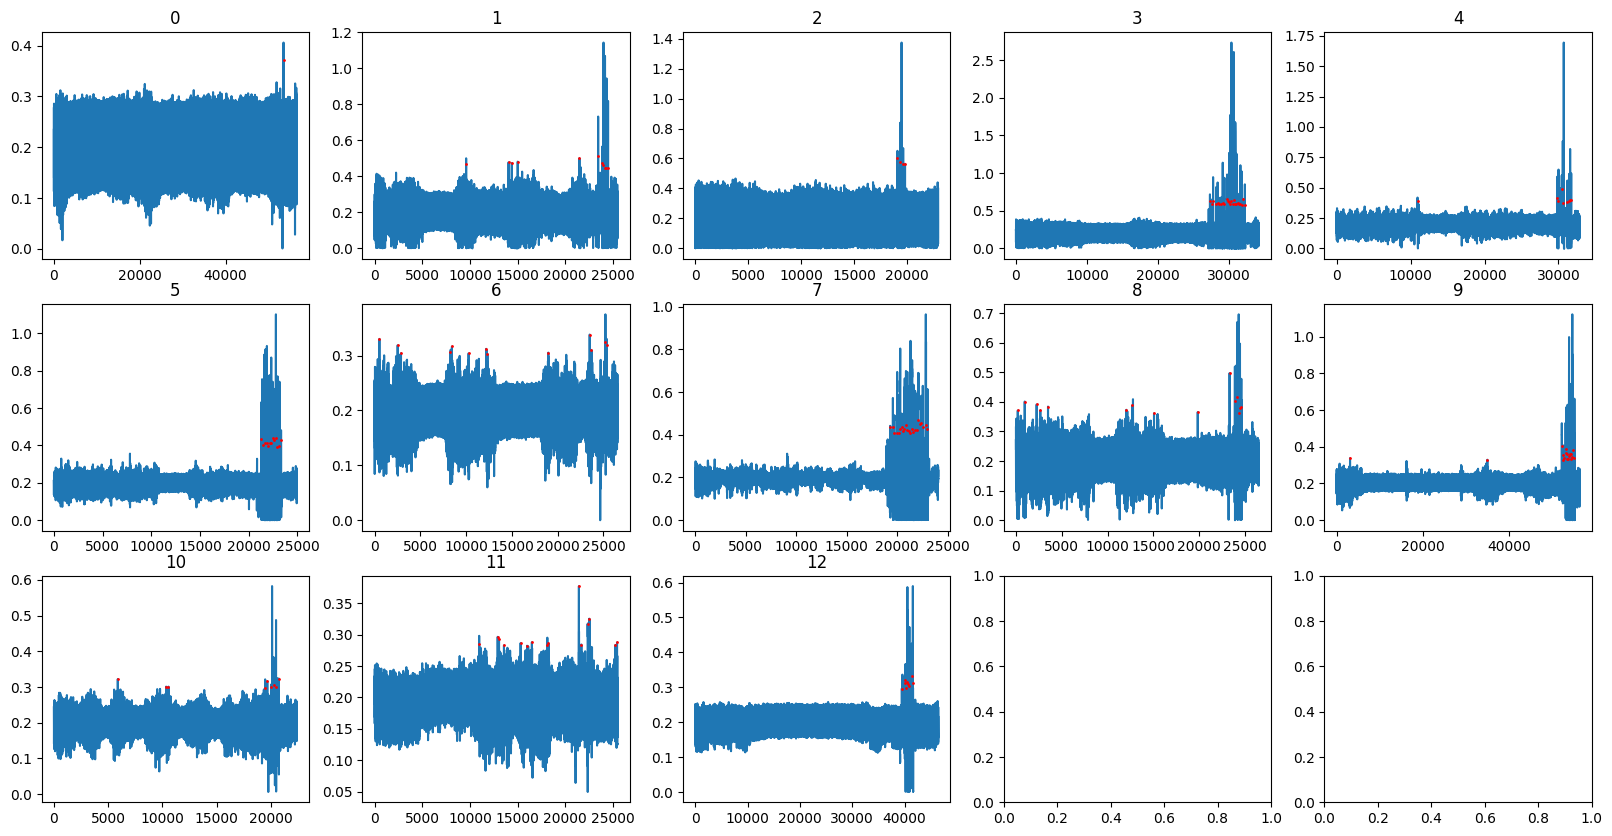

In [4]:
# find lick indices in nondownsampled data and get lick_onsets/lick_records/lick_rate in downsampled data--- tst

lick_onsets_tst = {}
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()

max_valid = 5
min_interval = 129   # refractory period in samples (ms)   the maximum ILI of C57 mice is around 129ms (see https://pmc.ncbi.nlm.nih.gov/articles/PMC3219432/)

for ani in data_tst_full:
    lick_onsets_tst[ani] = []

    lick_signal = np.clip(data_tst_full[ani]['lick'], a_min=None, a_max=max_valid)
    # lick_signal = gaussian_filter1d(lick_signal_raw, sigma=0.1)  # optional smoothing

    trial_start_indices = data_tst_full[ani]['trial_start_indices']

    # iterate over all trials
    for tri in range(len(trial_start_indices) - 1):
        start = trial_start_indices[tri]
        end = trial_start_indices[tri + 1]
        segment = lick_signal[start:end]
 
        threshold = np.median(segment) + 3 * np.std(segment)

        # find threshold crossings
        above = segment > threshold
        crossings = np.where((~above[:-1]) & (above[1:]))[0] + 1 

        # convert local indices to absolute indices
        if len(crossings) > 0:
            # enforce refractory period (in absolute frame)
            abs_cross = start + crossings
            if len(abs_cross) > 0:
                filtered = [abs_cross[0]]
                for idx in abs_cross[1:]:
                    if idx - filtered[-1] >= min_interval:
                        filtered.append(idx)
                lick_onsets_tst[ani].extend(filtered)

# convert to numpy arrays
for ani in lick_onsets_tst:
    
    lick_onsets_tst[ani] = np.array(lick_onsets_tst[ani])
    
    trial_start_indices = data_tst_full[ani]['trial_start_indices']
    start_trial = 121
    end_trial = 122
    start, end = trial_start_indices[start_trial], trial_start_indices[end_trial]
    lick_signal = data_tst_full[ani]['lick'] 
    axes[ani].plot(lick_signal[start:end])
    axes[ani].set_title(f'{ani}')
    # axes[ani].axhline(0.2,c='red')

    onsets_in_segment = lick_onsets_tst[ani][(lick_onsets_tst[ani] >= start) & (lick_onsets_tst[ani] < end)]
    print('animal',ani, len(onsets_in_segment), 'licks in trial', start_trial, 'to', end_trial)
    rel_onsets = onsets_in_segment - start
    axes[ani].scatter(
        rel_onsets,
        lick_signal[onsets_in_segment],
        color='red', s=1, zorder=3
    )

# Calculate the Lick Rate in full data

lick_rate_tst = {}
window_ms = 200  # 1-second sliding window
sampling_rate = 1000  # Hz
for ani in data_tst_full:
    # Make binary lick signal
    n_samples = len(data_tst_full[ani]['time'])
    lick_signal = np.zeros(n_samples)
    lick_signal[lick_onsets_tst[ani]] = 1
    # Sliding window average (licks per sample)
    rate_per_sample = uniform_filter1d(lick_signal, size=window_ms, mode='constant')
    # Convert to licks per second
    lick_rate_tst[ani] = rate_per_sample * sampling_rate


# Find the lick indices in the downsampled data and get a new lick_onsets_tst

lick_onsets_tst_ds = {}
for ani in data_tst_full:
    times_full = data_tst_full[ani]['time']
    times_ds = data_tst[ani]['time']
    lick_onsets_tst_ds[ani] = [] 
    for lick_ind in lick_onsets_tst[ani]:
        lick_time = times_full[lick_ind]
        i = np.argmin(np.abs(times_ds - lick_time))   # find the time_ds closest to lick_time and use that index
        if 0 <= i < len(times_ds): 
            lick_onsets_tst_ds[ani].append(i)
    lick_onsets_tst_ds[ani] = np.array(lick_onsets_tst_ds[ani])


# Get the lick_record and lick_rate in downsampled data

lick_record_tst = {}
for ani in data_tst:
    lick_record_tst[ani] = np.zeros(data_tst[ani]['lick'].shape[0])
    for num in lick_onsets_tst_ds[ani]:
        lick_record_tst[ani][num] = 1


lick_rate_tst_ds = {}
window_frames = 7
for ani in data_tst:
    lick_series = pd.Series(lick_record_tst[ani])
    lick_count = lick_series.rolling(window=window_frames, min_periods=1).sum() 
    lick_rate_tst_ds[ani] = np.array(lick_count)*7.5/window_frames   # Convert to licks/sec

In [5]:
# Add lick_rate and lick_record to data_ctl and tst
for ani in data_ctl:
    data_ctl[ani]['lick_rate']  = lick_rate_ctl_ds[ani]
    data_ctl[ani]['lick_record'] = lick_record_ctl[ani]
for ani in data_tst:
    data_tst[ani]['lick_rate']  = lick_rate_tst_ds[ani]
    data_tst[ani]['lick_record'] = lick_record_tst[ani]

# So far the lick_rate and lick_record look correct

-------------------------------------------------

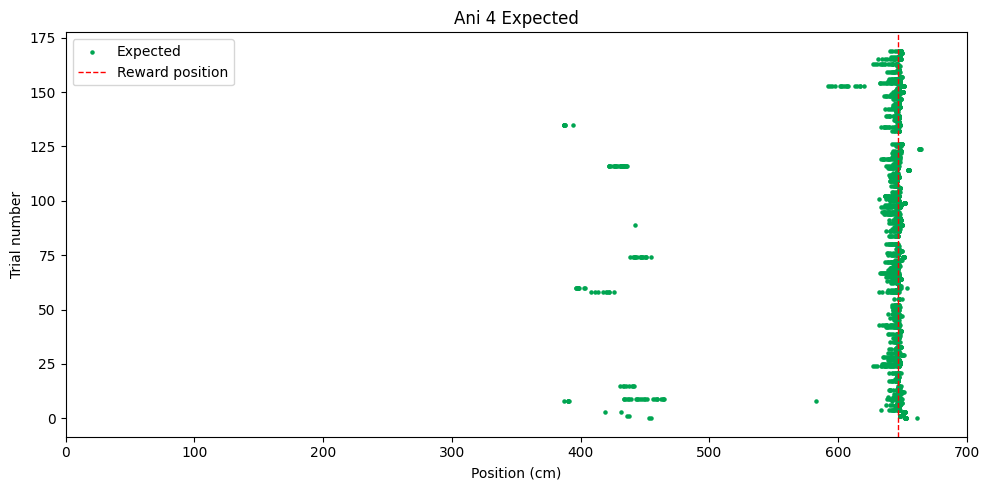

In [ ]:
aligned_exp, aligned_unexp = af_b.extract_lick_events_by_position(4, data_ctl, 'Expected',plot=True)

## ani 6 & 8 licked near the second landmark

------------------------------

In [328]:
# merge ctl and tst data
merged = {}
for k, v in data_ctl.items():
    merged[k] = v
offset = max(data_ctl.keys()) + 1
for k, v in data_tst.items():
    merged[k + offset] = v

In [329]:
# gratings and reward locations: grating 1 at 2.16, grating 2 at 3.7, reward at 4.62
data = merged
gr2_loc = [np.mean(data[ani]['real_position'][np.array(data[ani]['grating_indices']['gr_2'])[:,20]]) for ani in data]
gr1_loc = [np.mean(data[ani]['real_position'][np.array(data[ani]['grating_indices']['gr_1'])[:,20]]) for ani in data]
reward_loc = [np.mean(data[ani]['real_position'][np.array(data[ani]['reward_indices'])]) for ani in data]
print(np.mean(gr2_loc), np.mean(gr1_loc), np.mean(reward_loc))

3.7010630471068855 2.1589081750985017 4.618173459546927


In [330]:
merged.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [331]:
# Normalise Pupil data (subtracted and devided by baseline)
for ani in merged:
    merged[ani]['pupil_rel'] = (merged[ani]['pupil']-np.nanmedian(merged[ani]['pupil']))/np.nanmedian(merged[ani]['pupil'])

In [332]:
# Normalise Speed Data (subtracted by baseline)
for ani in data_ctl:
    merged[ani]['speed'] = merged[ani]['speed']-np.percentile(merged[ani]['speed'], 10)  # speed - percentile(speed)

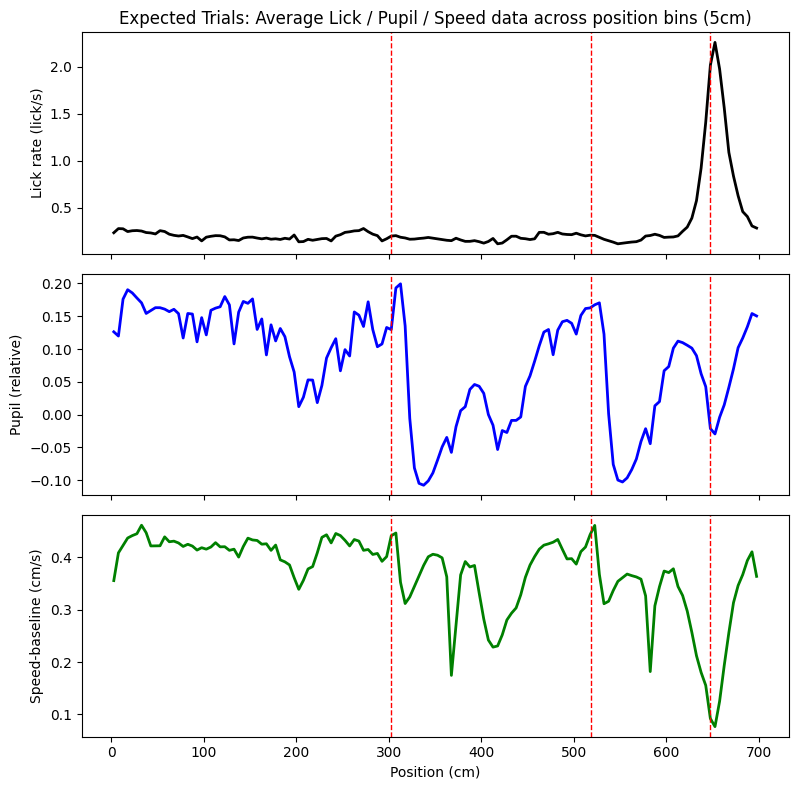

In [335]:
bin_size = 5  # cm
bins = np.arange(0, 700 + bin_size, bin_size)
n_bins = len(bins) - 1
bin_centers = (bins[:-1] + bins[1:]) / 2
animals = [0, 1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

lick_matrix = np.zeros((len(animals), n_bins))
speed_matrix = np.zeros((len(animals), n_bins))

for i,ani in enumerate(animals):
    # Predicted Trials Mask
    n_time = len(merged[ani]['lick_rate'])
    pred_mask = np.zeros(n_time, dtype=bool)
    trial_starts = merged[ani]['trial_start_indices']
    # expected = slice(0,16)
    pred_trials = merged[ani]['pred_trials']
    for t in pred_trials:
        start = trial_starts[t]
        if t < len(trial_starts) - 1:
            end = trial_starts[t+1]
        else:
            end = n_time 
        pred_mask[start:end] = True

    pos = merged[ani]['real_position'] * 700/5

    for b in range(n_bins):
        in_bin = (pos >= bins[b]) & (pos < bins[b+1]) & pred_mask
        if np.sum(in_bin) > 0:
            lick_matrix[i, b] = np.nanmean(merged[ani]['lick_rate'][in_bin])
            speed_matrix[i,b] = np.nanmean(merged[ani]['speed'][in_bin])
        else:
            lick_matrix[i, b] = 0
            speed_matrix[i, b] = 0

animals_pupil = [0, 4, 5, 7, 8, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
pupil_matrix = np.zeros((len(animals_pupil), n_bins))
for i,ani in enumerate(animals_pupil):
    # Predicted Trials Mask
    n_time = len(merged[ani]['lick_rate'])
    pred_mask = np.zeros(n_time, dtype=bool)
    trial_starts = merged[ani]['trial_start_indices']
    pred_trials = merged[ani]['pred_trials']
    for t in pred_trials:
        start = trial_starts[t]
        if t < len(trial_starts) - 1:
            end = trial_starts[t+1]
        else:
            end = n_time 
        pred_mask[start:end] = True

    pos = merged[ani]['real_position'] * 700/5

    for b in range(n_bins):
        in_bin = (pos >= bins[b]) & (pos < bins[b+1]) & pred_mask
        if np.sum(in_bin) > 0:
            pupil_matrix[i,b] = np.nanmean(merged[ani]['pupil_rel'][in_bin])
        else:
            pupil_matrix[i, b] = 0

lick_trace = np.nanmean(lick_matrix, axis=0)
pupil_trace = np.nanmean(pupil_matrix, axis=0)
speed_trace = np.nanmean(speed_matrix, axis=0)

lick_smooth = gaussian_filter1d(lick_trace, sigma=0.5)
pupil_smooth = gaussian_filter1d(pupil_trace, sigma=0.5)
speed_smooth = gaussian_filter1d(speed_trace, sigma=0.5)

reward_pos = 4.62 * 700 / 5
grat1_pos = 2.16 * 700/5
grat2_pos = 3.7 * 700/5

fig,axs = plt.subplots(3,1,figsize = (8,8), sharex=True)

# ----- Lick rate -----
axs[0].plot(bin_centers, lick_smooth, lw=2, color='black')
axs[0].axvline(x=grat1_pos, color='red', linestyle='--', linewidth=1)
axs[0].axvline(x=grat2_pos, color='red', linestyle='--', linewidth=1)
axs[0].axvline(x=reward_pos, color='red', linestyle='--', linewidth=1)
axs[0].set_ylabel("Lick rate (lick/s)")
axs[0].set_title(f"Expected Trials: Average Lick / Pupil / Speed data across position bins ({bin_size}cm)")

# ----- Pupil -----
axs[1].plot(bin_centers, pupil_smooth, lw=2, color='blue')
axs[1].axvline(x=grat1_pos, color='red', linestyle='--', linewidth=1)
axs[1].axvline(x=grat2_pos, color='red', linestyle='--', linewidth=1)
axs[1].axvline(x=reward_pos, color='red', linestyle='--', linewidth=1)
axs[1].set_ylabel("Pupil (relative)")

# ----- Speed -----
axs[2].plot(bin_centers, speed_smooth, lw=2, color='green')
axs[2].axvline(x=grat1_pos, color='red', linestyle='--', linewidth=1)
axs[2].axvline(x=grat2_pos, color='red', linestyle='--', linewidth=1)
axs[2].axvline(x=reward_pos, color='red', linestyle='--', linewidth=1)
axs[2].set_ylabel("Speed-baseline (cm/s)")
axs[2].set_xlabel("Position (cm)")

plt.tight_layout()
plt.show()

(2, 350)


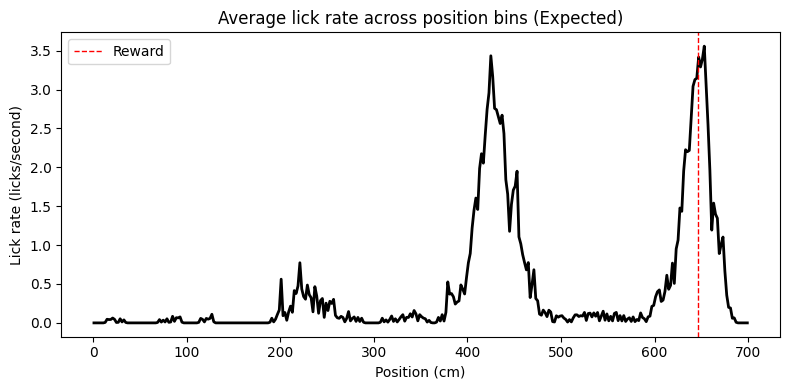

In [ ]:
# The plot for the two animals that lick at the second landmark

bin_size = 2  # cm
bins = np.arange(0, 700 + bin_size, bin_size)
n_bins = len(bins) - 1
bin_centers = (bins[:-1] + bins[1:]) / 2
# animals = [0, 1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
animals = [6,8]

lick_matrix = np.zeros((len(animals), n_bins))

for i,ani in enumerate(animals):
    # Predicted Trials Mask
    n_time = len(merged[ani]['lick_rate'])
    pred_mask = np.zeros(n_time, dtype=bool)
    trial_starts = merged[ani]['trial_start_indices']
    expected = slice(0,16)
    pred_trials = merged[ani]['pred_trials'][expected]
    for t in pred_trials:
        start = trial_starts[t]
        if t < len(trial_starts) - 1:
            end = trial_starts[t+1]
        else:
            end = n_time 
        pred_mask[start:end] = True

    pos = merged[ani]['real_position'] * 700/5

    for b in range(n_bins):
        in_bin = (pos >= bins[b]) & (pos < bins[b+1]) & pred_mask
        if np.sum(in_bin) > 0:
            lick_matrix[i, b] = np.nanmean(merged[ani]['lick_rate'][in_bin])
        else:
            lick_matrix[i, b] = 0

print(lick_matrix.shape)

lick_trace = np.nanmean(lick_matrix,axis=0)
lick_trace_smooth = gaussian_filter1d(lick_trace, sigma=0.5)
reward_pos = 4.62 * 700 / 5
plt.figure(figsize=(8, 4))
plt.plot(bin_centers, lick_trace_smooth, lw=2,color='black')
plt.axvline(x=reward_pos,color='red',linestyle='--',linewidth=1,label='Reward')
plt.xlabel("Position (cm)")
plt.ylabel("Lick rate (licks/second)")
plt.title("Average lick rate across position bins (Expected)")
plt.legend()
plt.tight_layout()
plt.show()

------------------------------------------------------

Lick Count

In [19]:
bin_size = 10  # cm
bins = np.arange(0, 700 + bin_size, bin_size)
n_bins = len(bins)-1
bin_centers = (bins[:-1] + bins[1:]) / 2
lick_matrix = np.zeros((len(data_ctl), n_bins))

for ani in data_ctl:
    
    data_ctl[ani]['lick_rate']
    aligned_exp, aligned_unexp = af_b.extract_lick_events_by_position(ani, data_ctl, 'Expected', False)
    pos = aligned_exp[:, 1]   
    trials = aligned_exp[:, 0]
    lick_counts, _ = np.histogram(pos, bins=bins)
    n_trials = len(np.unique(trials))
    lick_rate = lick_counts / n_trials
    lick_matrix[ani,:] = lick_rate

print(lick_matrix.shape)

(14, 70)


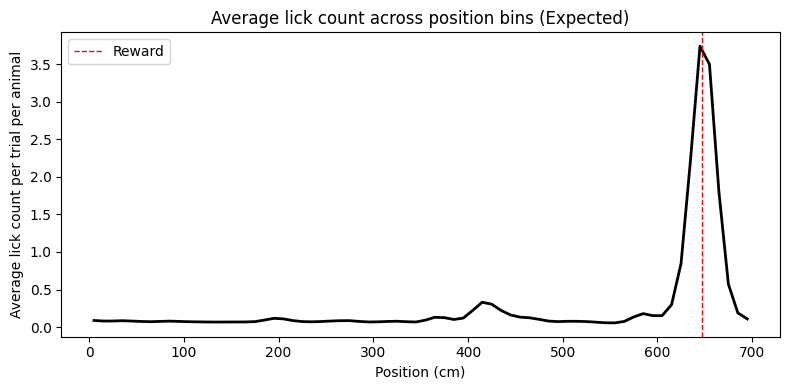

In [20]:
# Average lick number at the positions per trial averaged across animals
lick_trace = np.mean(lick_matrix,axis=0)
lick_trace_smooth = gaussian_filter1d(lick_trace, sigma=1)
reward_pos = 4.62 * 700 / 5

plt.figure(figsize=(8, 4))
plt.plot(bin_centers, lick_trace_smooth, lw=2,color='black')
plt.axvline(x=reward_pos,color='red',linestyle='--',linewidth=1,label='Reward')
plt.xlabel("Position (cm)")
plt.ylabel("Average lick count per trial per animal")
plt.title("Average lick count across position bins (Expected)")
plt.legend()
plt.tight_layout()
plt.show()

<Axes: >

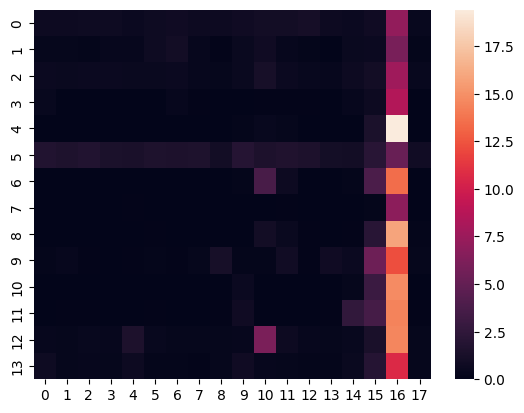

In [384]:
bin_size = 40  # cm
bins = np.arange(0, 700 + bin_size, bin_size)
n_bins = len(bins)-1
bin_centers = (bins[:-1] + bins[1:]) / 2
lick_matrix = np.zeros((len(data_ctl), n_bins))

for ani in data_ctl:
    aligned_exp, aligned_unexp = af_b.extract_lick_events_by_position(ani, data_ctl, 'Expected', False)
    pos = aligned_exp[:, 1]   
    trials = aligned_exp[:, 0]
    lick_counts, _ = np.histogram(pos, bins=bins)
    n_trials = len(data_ctl[ani]['pred_trials'])
    lick_rate = lick_counts / n_trials
    lick_matrix[ani,:] = lick_rate

sns.heatmap(lick_matrix)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

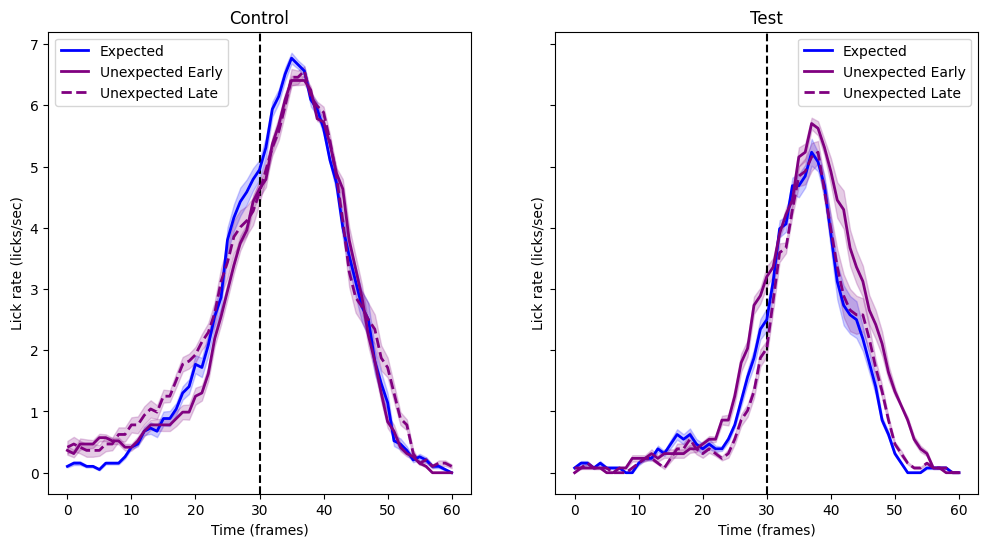

In [ ]:
#ctl vs tst --- downsampled lick rate

unexp_data = {}
for ani in animal_ctl:
    unexp_data[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2'][:6]:
        unexp_data[ani].append(lick_rate_ctl_ds[ani][range(data_ctl[ani]['reward_indices'][trial]-30,data_ctl[ani]['reward_indices'][trial]+31)])
exp_data = {}
for ani in animal_ctl:
    exp_data[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2'][6:12]:
        exp_data[ani].append(lick_rate_ctl_ds[ani][range(data_ctl[ani]['reward_indices'][trial-1]-30,data_ctl[ani]['reward_indices'][trial-1]+31)])
unexp_late_data = {}
for ani in animal_ctl:
    unexp_late_data[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2'][6:12]:
        unexp_late_data[ani].append(lick_rate_ctl_ds[ani][range(data_ctl[ani]['reward_indices'][trial]-30,data_ctl[ani]['reward_indices'][trial]+31)])

exp_color = 'blue'
unexp_color = 'purple'
# control
unexp_early = np.mean(np.stack([unexp_data[ani] for ani in animal_ctl]),axis = 1)
exp = np.mean(np.stack([exp_data[ani] for ani in animal_ctl]),axis = 1)
unexp_late = np.mean(np.stack([unexp_late_data[ani] for ani in animal_ctl]),axis = 1)

x_vals = np.arange(exp.shape[1])
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axes[0].axvline(30, linestyle='--', color='k')
af.plot_shaded_error(axes[0], x_vals, exp, color=exp_color, label='Expected')
af.plot_shaded_error(axes[0], x_vals, unexp_early, color=unexp_color, label='Unexpected Early')
af.plot_shaded_error(axes[0], x_vals, unexp_late, color=unexp_color, label='Unexpected Late', style='dash')
axes[0].set_title('Control')
axes[0].set_xlabel('Time (frames)')
axes[0].set_ylabel('Lick rate (licks/sec)')
axes[0].legend()

# tst
unexp_data = {}
for ani in animal_tst:
    unexp_data[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2'][:6]:
        unexp_data[ani].append(lick_rate_tst_ds[ani][range(data_tst[ani]['reward_indices'][trial]-30,data_tst[ani]['reward_indices'][trial]+31)])
exp_data = {}
for ani in animal_tst:
    exp_data[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2'][6:12]:
        exp_data[ani].append(lick_rate_tst_ds[ani][range(data_tst[ani]['reward_indices'][trial-1]-30,data_tst[ani]['reward_indices'][trial-1]+31)])
unexp_late_data = {}
for ani in animal_tst:
    unexp_late_data[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2'][6:12]:
        unexp_late_data[ani].append(lick_rate_tst_ds[ani][range(data_tst[ani]['reward_indices'][trial]-30,data_tst[ani]['reward_indices'][trial]+31)])
exp_color = 'blue'
unexp_color = 'purple'

# test
unexp_early = np.mean(np.stack([unexp_data[ani] for ani in animal_tst]), axis=1)
exp = np.mean(np.stack([exp_data[ani] for ani in animal_tst]), axis=1)
unexp_late = np.mean(np.stack([unexp_late_data[ani] for ani in animal_tst]), axis=1)

x_vals = np.arange(exp.shape[1])
axes[1].axvline(30, linestyle='--', color='k')
af.plot_shaded_error(axes[1], x_vals, exp, color=exp_color, label='Expected')
af.plot_shaded_error(axes[1], x_vals, unexp_early, color=unexp_color, label='Unexpected Early')
af.plot_shaded_error(axes[1], x_vals, unexp_late, color=unexp_color, label='Unexpected Late', style='dash')
axes[1].set_title('Test')
axes[1].set_xlabel('Time (frames)')
axes[1].set_ylabel('Lick rate (licks/sec)')
axes[1].legend()

lick plots - w and w/o bootstrapping
average all mice
remove mice that are licking in anticipation
lick latency pltos - make sure code is consistent w lick rate plots, use error bars

In [ ]:
# all animals with valid licking

ctl_animals = [0,1,2,3,4,5,6,7,8,9,10,11,12]
tst_animals = [1,2,3,5,7,9,10,12]

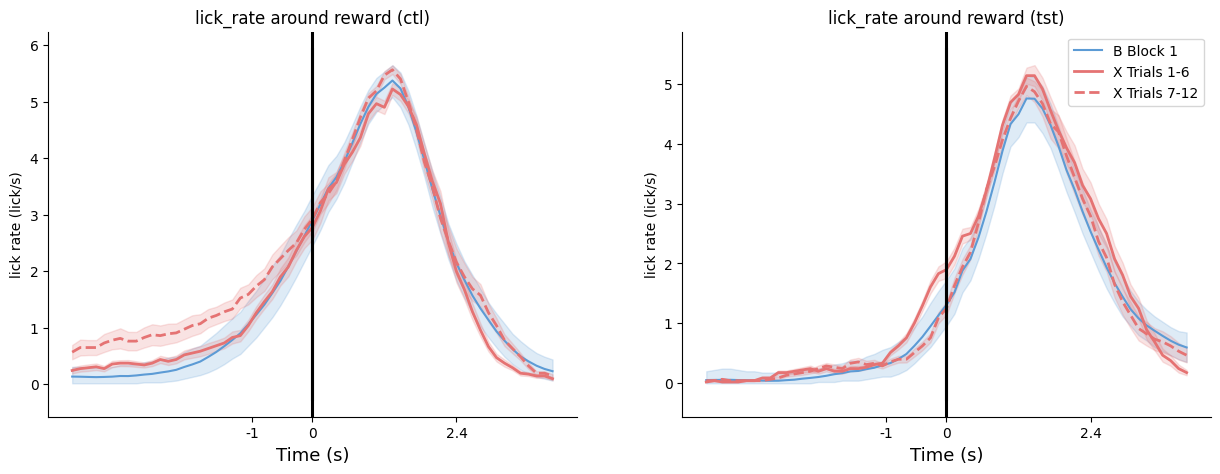

In [88]:
fig,axes = plt.subplots(1,2,figsize = (15,5))
af_b.bootstrap(data_ctl, animals = ctl_animals,  axes = axes[0], all_axes = axes, behv = 'lick_rate', stim_type = 'rw',  n_boot=1000, early_tri=slice(0,6),late_tri=slice(6,12))
af_b.bootstrap(data_tst, animals = tst_animals,  axes = axes[1], all_axes = axes, behv = 'lick_rate', stim_type = 'rw',  n_boot=1000, early_tri=slice(0,6),late_tri=slice(6,12))

IndexError: tuple index out of range

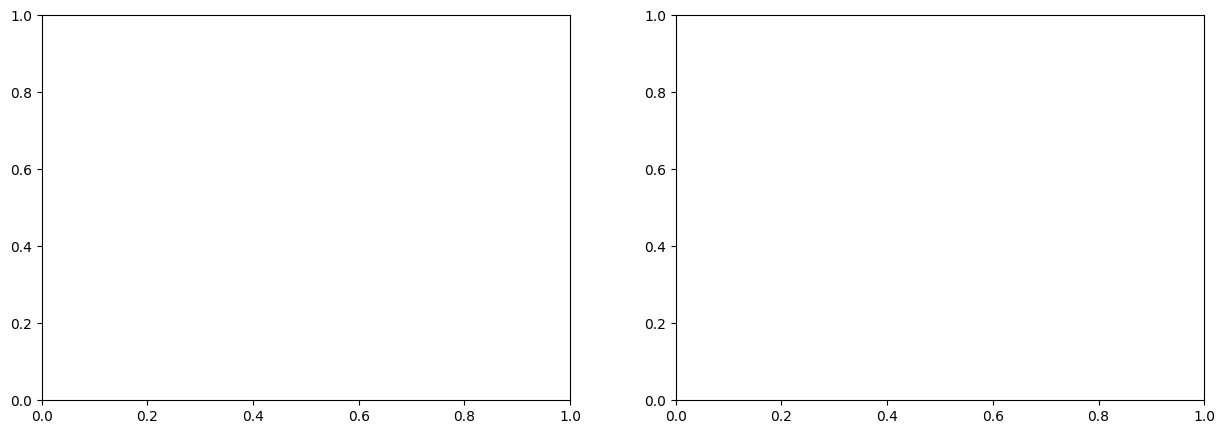

In [89]:
fig,axes = plt.subplots(1,2,figsize = (15,5))
af_b.avg_plot(data_ctl, animals = ctl_animals,  axes = axes[0], all_axes = axes, behv = 'lick_rate', stim_type = 'rw', early_tri=slice(0,6),late_tri=slice(6,12),exp_tri = slice(0,16))
af_b.avg_plot(data_tst, animals = tst_animals,  axes = axes[1], all_axes = axes, behv = 'lick_rate', stim_type = 'rw', early_tri=slice(0,6),late_tri=slice(6,12),exp_tri = slice(0,16))

In [85]:
# Strong anticipatory licking animals
ctl_animals = [3,6,8,9,10,11]
tst_animals = [1,5,10,12]

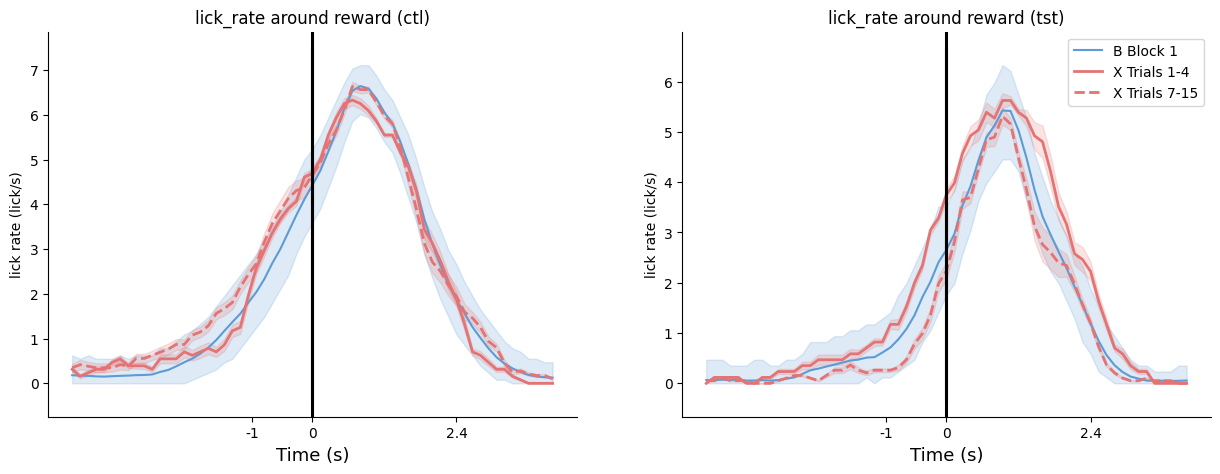

In [86]:
fig,axes = plt.subplots(1,2,figsize = (15,5))
af_b.bootstrap(data_ctl, animals = ctl_animals,  axes = axes[0], all_axes = axes, behv = 'lick_rate', stim_type = 'rw',  n_boot=1000, early_tri=slice(0,4),late_tri=slice(6,15))
af_b.bootstrap(data_tst, animals = tst_animals,  axes = axes[1], all_axes = axes, behv = 'lick_rate', stim_type = 'rw',  n_boot=1000, early_tri=slice(0,4),late_tri=slice(6,15))

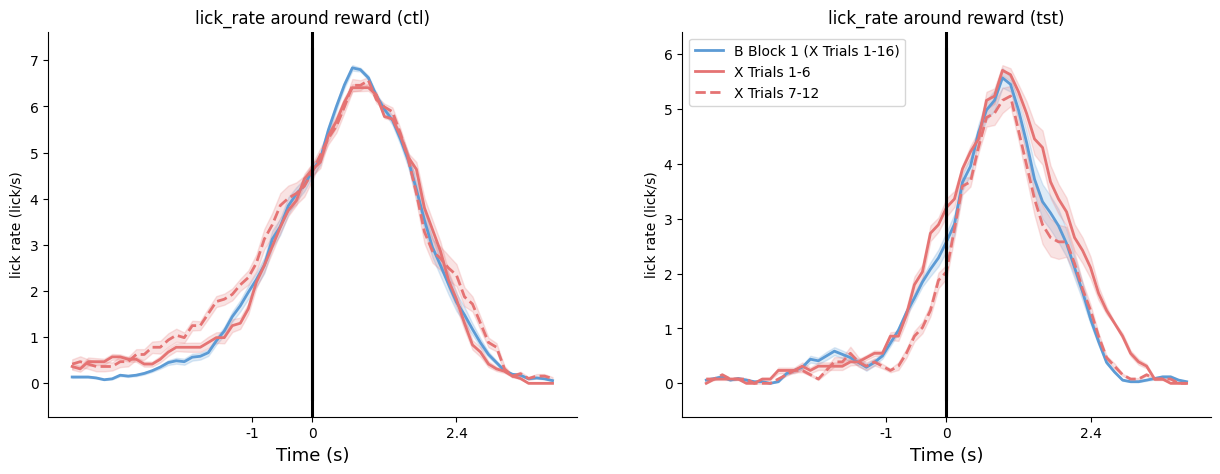

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (15,5))
af_b.avg_plot(data_ctl, animals = ctl_animals,  axes = axes[0], all_axes = axes, behv = 'lick_rate', stim_type = 'rw', early_tri=slice(0,6),late_tri=slice(6,12))
af_b.avg_plot(data_tst, animals = tst_animals,  axes = axes[1], all_axes = axes, behv = 'lick_rate', stim_type = 'rw', early_tri=slice(0,6),late_tri=slice(6,12))

In [ ]:
# all animals with valid licking

ctl_animals = [1,2,3,4,6,7,8,9,10,11,12]
tst_animals = [1,2,3,5,7,9,10,12]

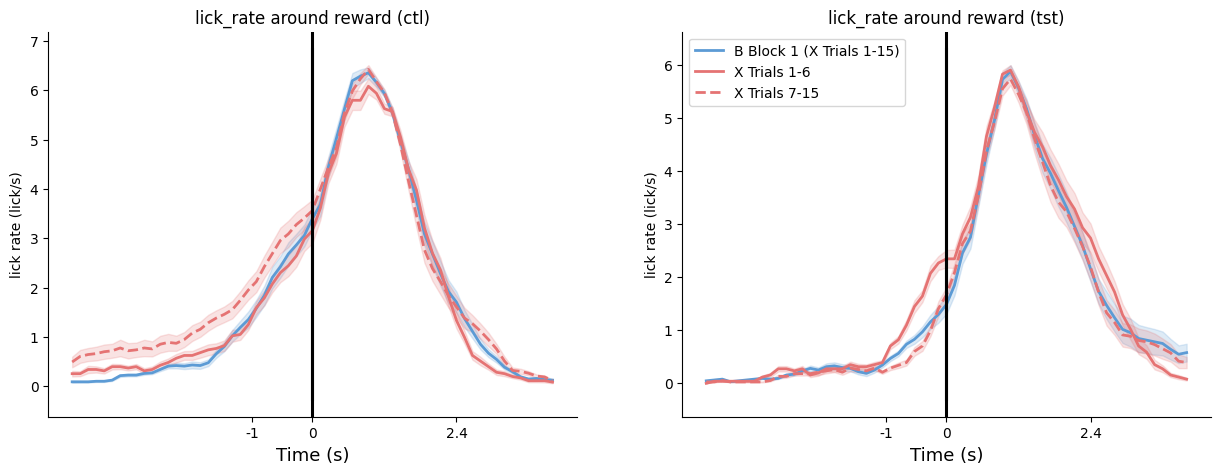

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (15,5))
af_b.avg_plot(data_ctl, animals = ctl_animals,  axes = axes[0], all_axes = axes, behv = 'lick_rate', stim_type = 'rw', early_tri=slice(0,6),late_tri=slice(6,15), exp_tri=slice(0,15))
af_b.avg_plot(data_tst, animals = tst_animals,  axes = axes[1], all_axes = axes, behv = 'lick_rate', stim_type = 'rw', early_tri=slice(0,6),late_tri=slice(6,15), exp_tri=slice(0,15))

In [ ]:
# Strong anticipatory licking animals
ctl_animals = [3,6,8,9,10,11]
tst_animals = [1,5,10,12]

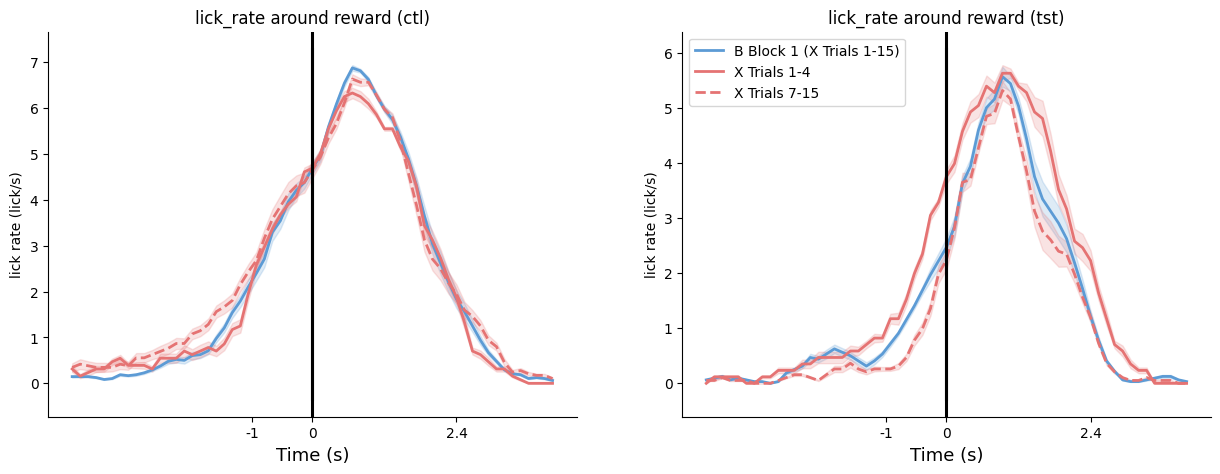

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (15,5))
af_b.avg_plot(data_ctl, animals = ctl_animals,  axes = axes[0], all_axes = axes, behv = 'lick_rate', stim_type = 'rw', early_tri=slice(0,4),late_tri=slice(6,15), exp_tri=slice(0,15))
af_b.avg_plot(data_tst, animals = tst_animals,  axes = axes[1], all_axes = axes, behv = 'lick_rate', stim_type = 'rw', early_tri=slice(0,4),late_tri=slice(6,15), exp_tri=slice(0,15))

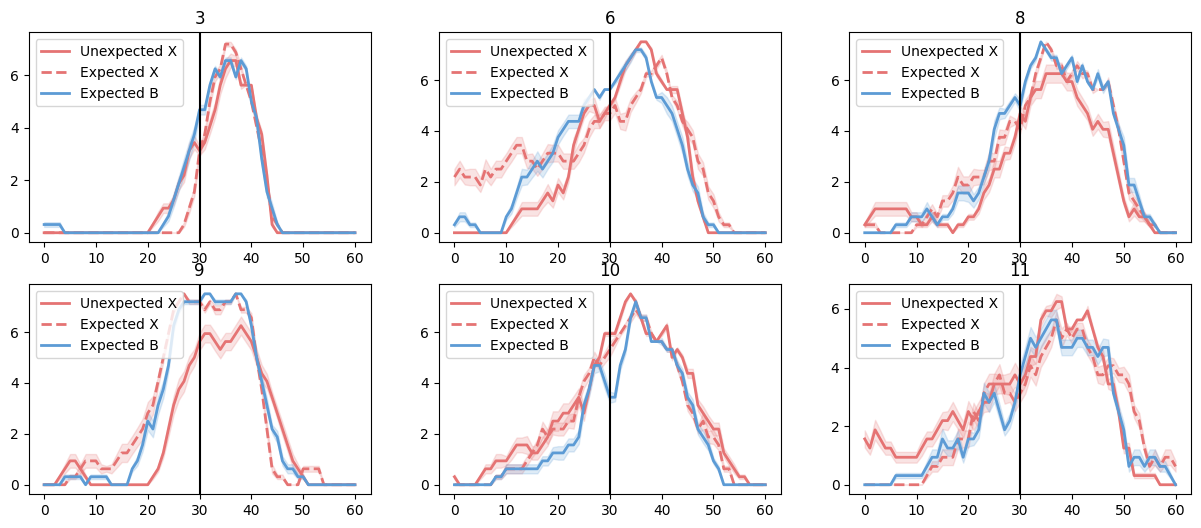

In [ ]:
# Pupil Size near reward (Ctl)
unexp_rw = {}
exp_rw = {}
for ani in data_ctl:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        unexp_rw[ani].append(range(data_ctl[ani]['reward_indices'][trial]-30,data_ctl[ani]['reward_indices'][trial]+31)) 
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        exp_rw[ani].append(range(data_ctl[ani]['reward_indices'][trial-1]-30,data_ctl[ani]['reward_indices'][trial-1]+31))

fig, axes = plt.subplots(2, 3, figsize=(15, 6)) 
axes = axes.flatten()
t_frames = 61
for i, ani in enumerate(ctl_animals):
    ax = axes[i]
    af.plot_shaded_error(ax, range(t_frames), lick_rate_ctl_ds[ani][unexp_rw[ani][:6]], color='#E57373', alpha=0.2, label='Unexpected X')
    af.plot_shaded_error(ax, range(t_frames), lick_rate_ctl_ds[ani][unexp_rw[ani][6:12]], color='#E57373', alpha=0.2, style='dash', label='Expected X')
    af.plot_shaded_error(ax, range(t_frames), lick_rate_ctl_ds[ani][exp_rw[ani][6:12]], color='#5C9BD5', alpha=0.2, label= 'Expected B')
    ax.axvline([30], color='black')
    ax.set_title(f'{ani}')
    ax.legend()

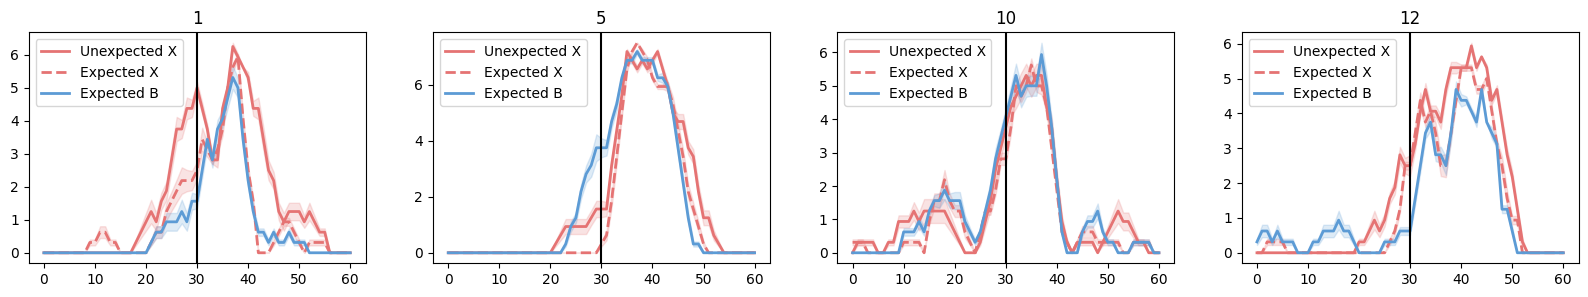

In [ ]:
# Pupil Size near reward (Test)
unexp_rw = {}
exp_rw = {}
for ani in data_tst:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        unexp_rw[ani].append(range(data_tst[ani]['reward_indices'][trial]-30,data_tst[ani]['reward_indices'][trial]+31)) 
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        exp_rw[ani].append(range(data_tst[ani]['reward_indices'][trial-1]-30,data_tst[ani]['reward_indices'][trial-1]+31))

fig, axes = plt.subplots(1, 4, figsize=(20, 3)) 
axes = axes.flatten()
t_frames = 61
for i, ani in enumerate(tst_animals):
    ax = axes[i]
    af.plot_shaded_error(ax, range(t_frames), lick_rate_tst_ds[ani][unexp_rw[ani][:6]], color='#E57373', alpha=0.2, label='Unexpected X')
    af.plot_shaded_error(ax, range(t_frames), lick_rate_tst_ds[ani][unexp_rw[ani][6:12]], color='#E57373', alpha=0.2, style='dash', label='Expected X')
    af.plot_shaded_error(ax, range(t_frames), lick_rate_tst_ds[ani][exp_rw[ani][6:12]], color='#5C9BD5', alpha=0.2, label= 'Expected B')
    ax.axvline([30], color='black')
    ax.set_title(f'{ani}')
    ax.legend()

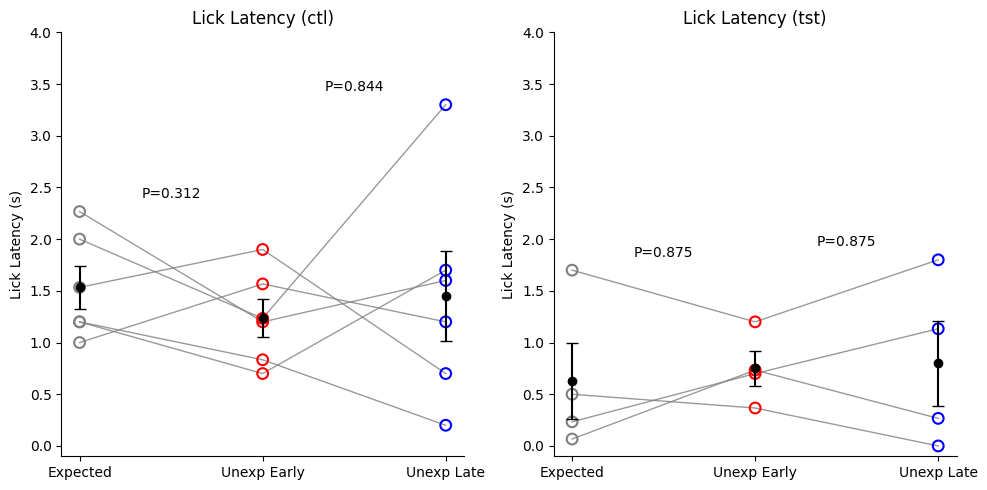

In [ ]:
# Lick latency three points plot  --- 4 seconds prior to reward

fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

unexp_rw = {}
exp_rw = {}
for ani in data_ctl:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        unexp_rw[ani].append(range(data_ctl[ani]['reward_indices'][trial]-30,data_ctl[ani]['reward_indices'][trial]+31)) 
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        exp_rw[ani].append(range(data_ctl[ani]['reward_indices'][trial-1]-30,data_ctl[ani]['reward_indices'][trial-1]+31))

results = []
for ani in ctl_animals:
    lick_exp = lick_record_ctl[ani][exp_rw[ani][6:10]][:,:30] 
    first_lick_exp_B = []
    for row in lick_exp:
        ones = np.where(row == 1)[0]  
        if len(ones) > 0:
            first_lick_exp_B.append(30 - ones[0]) # lick prior to reward
        else:
            first_lick_exp_B.append(0)
    lick_unexp_early = lick_record_ctl[ani][unexp_rw[ani][:4]][:,:30]
    first_lick_unexp_X = []
    for row in lick_unexp_early:
        ones = np.where(row == 1)[0]  
        if len(ones) > 0:
            first_lick_unexp_X.append(30 - ones[0]) 
        else:
            first_lick_unexp_X.append(0)
    lick_unexp_late = lick_record_ctl[ani][unexp_rw[ani][6:10]][:,:30]
    first_lick_exp_X = []
    for row in lick_unexp_late:
        ones = np.where(row == 1)[0]
        if len(ones) > 0:
            first_lick_exp_X.append(30 - ones[0]) 
        else:
            first_lick_exp_X.append(0)

    results.append([np.mean(first_lick_exp_B), np.mean(first_lick_unexp_X), np.mean(first_lick_exp_X)])
results = np.array(results)/7.5  # convert frames to seconds

colors = ['gray', 'red', 'blue']
x_positions = [1,2,3]
for i, xpos in enumerate(x_positions):
    axes[0].scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
for animal in results:
    axes[0].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line

means = np.mean(results, axis=0)
sem = np.std(results, axis=0, ddof=1) / np.sqrt(results.shape[0])
axes[0].errorbar(x_positions, means, yerr=sem, fmt='o', color='black',
                 capsize=4, lw=1.5, zorder=6)

# pairwise test
pairs = [(0,1), (0,2), (1,2)]
labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
pvals = []
for (i,j), label in zip(pairs, labels):
    stat, p = wilcoxon(results[:,i], results[:,j])
    pvals.append(p)
    # print(label, "Wilcoxon p =", p)
axes[0].set_ylim([-0.1,4])
axes[0].set_xticks([1, 2, 3])
axes[0].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
i, j = 0, 1 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1
axes[0].text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
i, j = 1, 2 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1  
axes[0].text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
axes[0].set_title('Lick Latency (ctl)')
axes[0].set_ylabel('Lick Latency (s)')

unexp_rw = {}
exp_rw = {}
for ani in tst_animals:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        unexp_rw[ani].append(range(data_tst[ani]['reward_indices'][trial]-30,data_tst[ani]['reward_indices'][trial]+31)) 
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        exp_rw[ani].append(range(data_tst[ani]['reward_indices'][trial-1]-30,data_tst[ani]['reward_indices'][trial-1]+31))

results = []
for ani in tst_animals:
    lick_exp = lick_record_tst[ani][exp_rw[ani][6:10]][:,:30]
    first_lick_exp_B = []
    for row in lick_exp:
        ones = np.where(row == 1)[0]  
        if len(ones) > 0:
            first_lick_exp_B.append(30 - ones[0]) # lick prior to reward
        else:
            first_lick_exp_B.append(0)
    lick_unexp_early = lick_record_tst[ani][unexp_rw[ani][:4]][:,:30]
    first_lick_unexp_X = []
    for row in lick_unexp_early:
        ones = np.where(row == 1)[0]  
        if len(ones) > 0:
            first_lick_unexp_X.append(30 - ones[0]) 
        else:
            first_lick_unexp_X.append(0)
    lick_unexp_late = lick_record_tst[ani][unexp_rw[ani][6:10]][:,:30]
    first_lick_exp_X = []
    for row in lick_unexp_late:
        ones = np.where(row == 1)[0]
        if len(ones) > 0:
            first_lick_exp_X.append(30 - ones[0]) 
        else:
            first_lick_exp_X.append(0)

    results.append([np.mean(first_lick_exp_B), np.mean(first_lick_unexp_X), np.mean(first_lick_exp_X)])
results = np.array(results)/7.5  # convert frames to seconds

colors = ['gray', 'red', 'blue']
x_positions = [1,2,3]
for i, xpos in enumerate(x_positions):
    axes[1].scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
for animal in results:
    axes[1].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line
means = np.mean(results, axis=0)
sem = np.std(results, axis=0, ddof=1) / np.sqrt(results.shape[0])
axes[1].errorbar(x_positions, means, yerr=sem, fmt='o', color='black',
                 capsize=4, lw=1.5, zorder=6)

# pairwise test
pairs = [(0,1), (0,2), (1,2)]
labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
pvals = []
for (i,j), label in zip(pairs, labels):
    stat, p = wilcoxon(results[:,i], results[:,j])
    pvals.append(p)
    # print(label, "Wilcoxon p =", p)
axes[1].set_ylim([-0.1,4])
axes[1].set_xticks([1, 2, 3])
axes[1].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
i, j = 0, 1 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1
axes[1].text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
i, j = 1, 2 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1  
axes[1].text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
axes[1].set_title('Lick Latency (tst)')
axes[1].set_ylabel('Lick Latency (s)')

plt.tight_layout()
plt.show()